### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 8
### Due: Saturday, Apr 6th at 11.59pm CT
---

## Only one problem this week

1. Use the following code snippet to read in SDSS galaxy color data.
<!--```
from astroML.datasets import fetch_sdss_galaxy_colors
data = fetch_sdss_galaxy_colors()
```-->

`data = np.load('../hw_data/hw8_data_1.npy')`

This is a structured numpy array. Find and print all of the column names. Using the data, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. How many regular galaxies and how many quasars are in this sample?


2. Make a scatter plot of $(u-g)$ versus $(g-r)$, color coding by galaxy or quasar class. The plot should include appropriate axis labels and a legend. Set `xlim` between -0.5 and 2.5, and `ylim` between -0.5 and 1.5.


3. Stack all colors and the redshift into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing.


4. Create a compact `for` loop that iterates over the fitting of a Gaussian Naive Bayes classification algorithm to successively more features of the data. Within the loop, compute and plot an ROC curve. The end result should be a plot showing ROC curves for GNB classification with more and more features of the data, with appropriate axis labels and a legend. Use `xlim` between 0 and 0.01. Which feature seems to make the classification trivially easy? *Note: `predict_proba` returns an array with as many columns as classes. You've labeled quasars as $1$, so for the ROC curve you must make sure to access the relevant quasar probability-- you can find this by accessing the **classes_** attribute of the estimator.*


5. Repeat (4) for Quadratic Discriminant Analysis. 


6. Let's try classification with GMM Bayes. Restrict the training and testing to be just on the $4$ colors. Iterate now over number of components in the GMM Bayes fit up to $10$, plotting ROC curves for all, and find the number of components that gives the best performance.


7. Repeat (6) for $K$-nearest neighbor classification, looping over number of neighbors between 5 and 100 in steps of 10. Find the number that gives the best performance. 


8. Repeat (6) for Decision Tree classification, looping over the maximum tree depth between 1 and 10. Find the number that gives the best performance. 


9. Finally, plot the ROC curves for GNB, QDA, and the best-performing GMMBayes, KNN, and DT classification algorithms, all using just the 4 colors. What is the overall best-performing classifier? 


10. Make a 2-panel plot, showing in the left panel the color-coded training data in $(u-g)$ versus $(g-r)$ (similar to item 2 above), and in the right panel the same features of the testing data color coded by their predicted class from the tuned best-performing classifier. 

In [19]:
from astroML.datasets import fetch_sdss_galaxy_colors
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc
#data = fetch_sdss_galaxy_colors()

In [3]:
data =np.load('/Users/mcgowkb1/ASTR8070/repos/astr_8070_s24/coursework/homeworks/hw_data/hw8_data_1.npy')
print("Column names:", data.dtype.names)

Column names: ('u', 'g', 'r', 'i', 'z', 'specClass', 'redshift', 'redshift_err')


In [11]:
# Sort colors
ug = data['u'] - data['g']
gr = data['g'] - data['r']
ri = data['r'] - data['i']
iz = data['i'] - data['z']

# Extract redshift & spectral class
redshift = data['redshift']
spectral_class = data['specClass']
redshift_error = data['redshift_err']

# Number of regular galaxies and quasars
num_galaxies = 0
num_quasars = 0
for spec_class in spectral_class:
    if spec_class == 'GALAXY':
        num_galaxies += 1
    elif spec_class == 'QSO':
        num_quasars += 1
#print(spectral_class)
print("Number of regular galaxies:", num_galaxies)
print("Number of quasars:", num_quasars)


Number of regular galaxies: 42808
Number of quasars: 7192


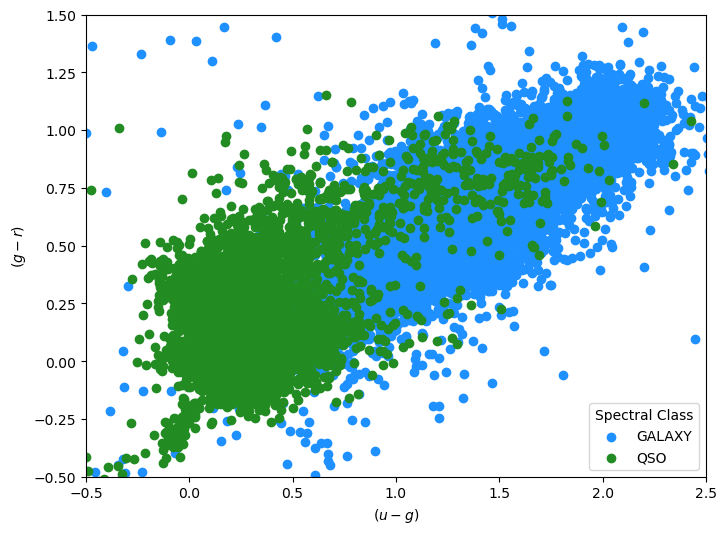

In [15]:
# Convert to strings
spectral_class_str = np.array([str(class_) for class_ in spectral_class])

# Set color for galaxy and quasar classes
colors = {'GALAXY': 'dodgerblue', 'QSO': 'forestgreen'}

# Plot Spectral Classes
plt.figure(figsize=(8, 6))
for spec_class in np.unique(spectral_class_str):
    mask = spectral_class_str == spec_class
    plt.scatter(ug[mask], gr[mask], color=colors[spec_class], label=spec_class)

plt.xlabel('$(u-g)$')
plt.ylabel('$(g-r)$')
plt.xlim(-0.5, 2.5)
plt.ylim(-0.5, 1.5)
plt.legend(title='Spectral Class')
plt.show()


In [18]:
# Stack colors and redshift into a data matrix X
X = np.column_stack((ug, gr, ri, iz, redshift))

# Create target label array
y = (spectral_class == b'QSO').astype(int)

# Perform train-test split
#Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)


In [26]:
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

# Features to use
features = ['$(u-g)$', '$(g-r)$', '$(r-i)$', '$(i-z)$', 'redshift']
X_list = [X[:, :i+1] for i in range(X.shape[1])]  # Include all features

# Create figure
plt.figure(figsize=(10, 8))

# Train-test split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

for i, X_subset in enumerate(X_list):
    if X_subset.shape[1] == 0:
        continue  # Skip empty subsets
    
    # Fit GNB model
    clf = GaussianNB()
    clf.fit(Xtrain[:, :i+1], ytrain)
    
    # Compute ROC curve
    y_score = clf.predict_proba(Xtest[:, :i+1])[:, clf.classes_ == 1]
    fpr, tpr, _ = roc_curve(ytest, y_score)
    
    # Compute AUC
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{features[i]} (AUC = {roc_auc:.2f})')

# Set labels and limits
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim(0, 0.01)
plt.ylim(0, 1)
plt.title('ROC curves for GNB classification with different features')
plt.legend()
plt.show()


ValueError: Found array with 0 feature(s) (shape=(10000, 0)) while a minimum of 1 is required.

<Figure size 1000x800 with 0 Axes>

SRT: It's a pity not to have the full solution here, Kaylah. I can only give minimal points. -40 points.